# Lab 5 Wide and Deep Neural Networks
* Nicholas Larsen
* Steven Larsen

Dataset: https://www.kaggle.com/radmirzosimov/telecom-users-dataset?select=telecom_users.csv

## Feature Description:
* Unnamed: Does not have information to what this means, it is just dropped for our purposes
* customerID: This is a unique identifier for each customer, this does not have any meaning other than for indentifying, it will be droped
* gender: The gender of the client
* SeniorCitizen: Whether or not the client is a senior citizen (0) or (1) if not
* Partner: Yes if the client is married, no if not
* Dependents: Yes if the client has dependants, no if not
* tenure: amount of months with the company
* PhoneService: yes if a phone is installed, no if not
* MultileLines: Yes if there is 2 or more lines, no if 1 line, no phone service if there is no phone service (3 categories)
* InternetService: Fiber optic, DSL, No
* OnlineSecurity: Yes if the online security service is activated, no if not, no internet service if no internet is used
* OnlineBackup: Yes if the backup service is enabled, no if not, no internet service is there is no internet for the client
* DeviceProtection: Yes if device protections is used, no if not, no internet service if no internet is used
* TechSupport: Yes if tech support service is connected, no if not, and no internet service if there is no internet used
* StreamingTV: Yes if the streaming TV service is activated, no if not and no internet service if there is no internet used
* StreamingMovies: yes if the srreaming cinema service is activated, no if not and no internet service if there is no internet used
* Contract: type of contrant, month-to-month, one year or two year
* PaperlessBilling: Pyament method, eletronic check, mailed check, bank, creditcard
* MonthlyCharges: current monthly payment
* TotalCharges: the total charges the client has paid to date
* Churn: (target feature) whether or not the client continued after the contract.

## Loading the data

In [1]:
import pandas as pd
from copy import deepcopy
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import concatenate
import tensorflow as tf
from sklearn import metrics as mt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model
from sklearn import metrics as mt
from tensorflow import keras
import missingno as mn

In [2]:
headers = ['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']

dtypes = {'encounter_id':'str', 'patient_nbr':'str', 
           'race':'str', 'gender':'str', 
           'age':'str', 'weight':'str',
           'admission_type_id':'str', 'discharge_disposition_id':'str', 
           'admission_source_id':'str', 'time_in_hospital':'str', 
           'payer_code':'str', 'medical_specialty':'str',
           'num_lab_procedures':'str', 'num_procedures':'str', 
           'num_medications':'str','number_outpatient':'str', 
           'number_emergency':'str', 'number_inpatient':'str', 
           'diag_1':'str', 'diag_2':'str', 'diag_3':'str', 
           'number_diagnoses':'str', 'max_glu_serum':'str', 
           'A1Cresult':'str', 'metformin':'str', 
           'repaglinide':'str', 'nateglinide':'str', 
           'chlorpropamide':'str', 'glimepiride':'str', 
           'acetohexamide':'str', 'glipizide':'str', 
           'glyburide':'str', 'tolbutamide':'str',
           'pioglitazone':'str', 'rosiglitazone':'str', 
           'acarbose':'str', 'miglitol':'str', 
           'troglitazone':'str', 'tolazamide':'str', 
           'examide':'str', 'citoglipton':'str', 
           'insulin':'str', 'glyburide-metformin':'str', 
           'glipizide-metformin':'str', 'glimepiride-pioglitazone':'str', 
           'metformin-rosiglitazone':'str',
           'metformin-pioglitazone':'str', 'change':'str', 
           'diabetesMed':'str', 'readmitted':'str'}

convert_to_numeric = ['num_lab_procedures','discharge_disposition_id','admission_source_id'
                   ,'time_in_hospital','num_lab_procedures','num_procedures','num_medications',
                   'number_outpatient','number_emergency','number_inpatient','diag_1','diag_2',
                   'diag_3']
df_original = pd.read_csv('../diabetic_data.csv',dtype=dtypes)


In [3]:
for col in convert_to_numeric:
    df_original[col] = pd.to_numeric(df_original[col], errors='coerce')

<AxesSubplot:>

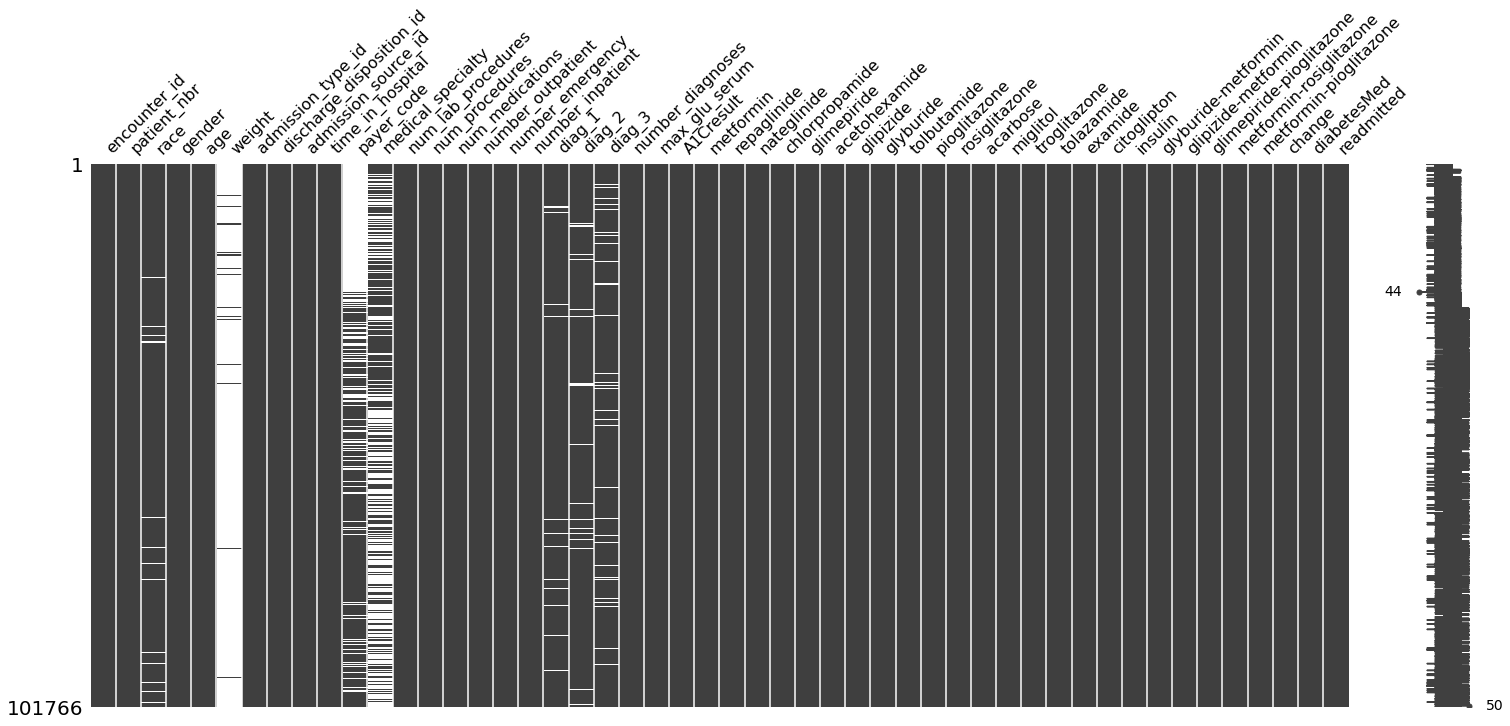

In [4]:
mn.matrix(df_original)

<AxesSubplot:>

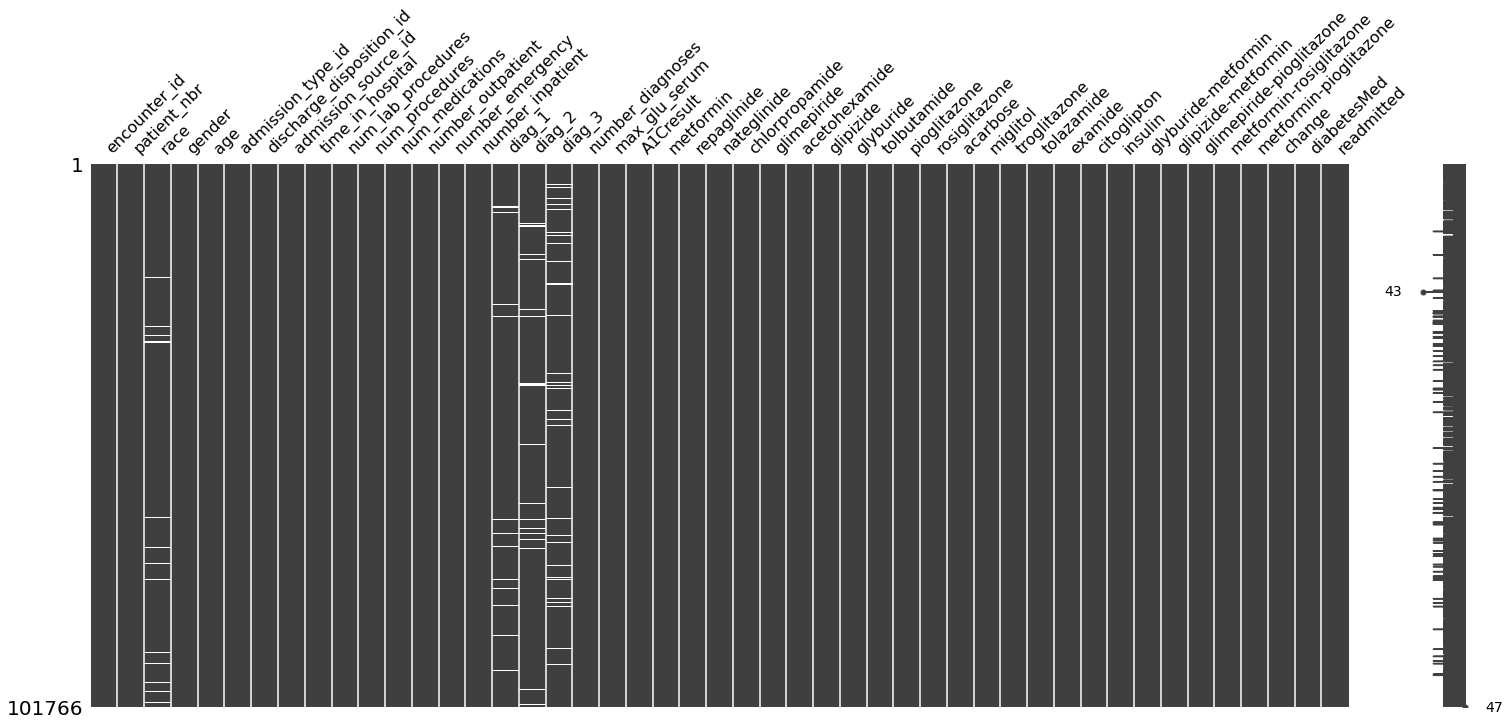

In [5]:
df_original = df_original.drop(columns=['weight','payer_code','medical_specialty'])
mn.matrix(df_original)

In [6]:
df_original.gender.unique()

array(['Female', 'Male', 'Unknown/Invalid'], dtype=object)

<AxesSubplot:>

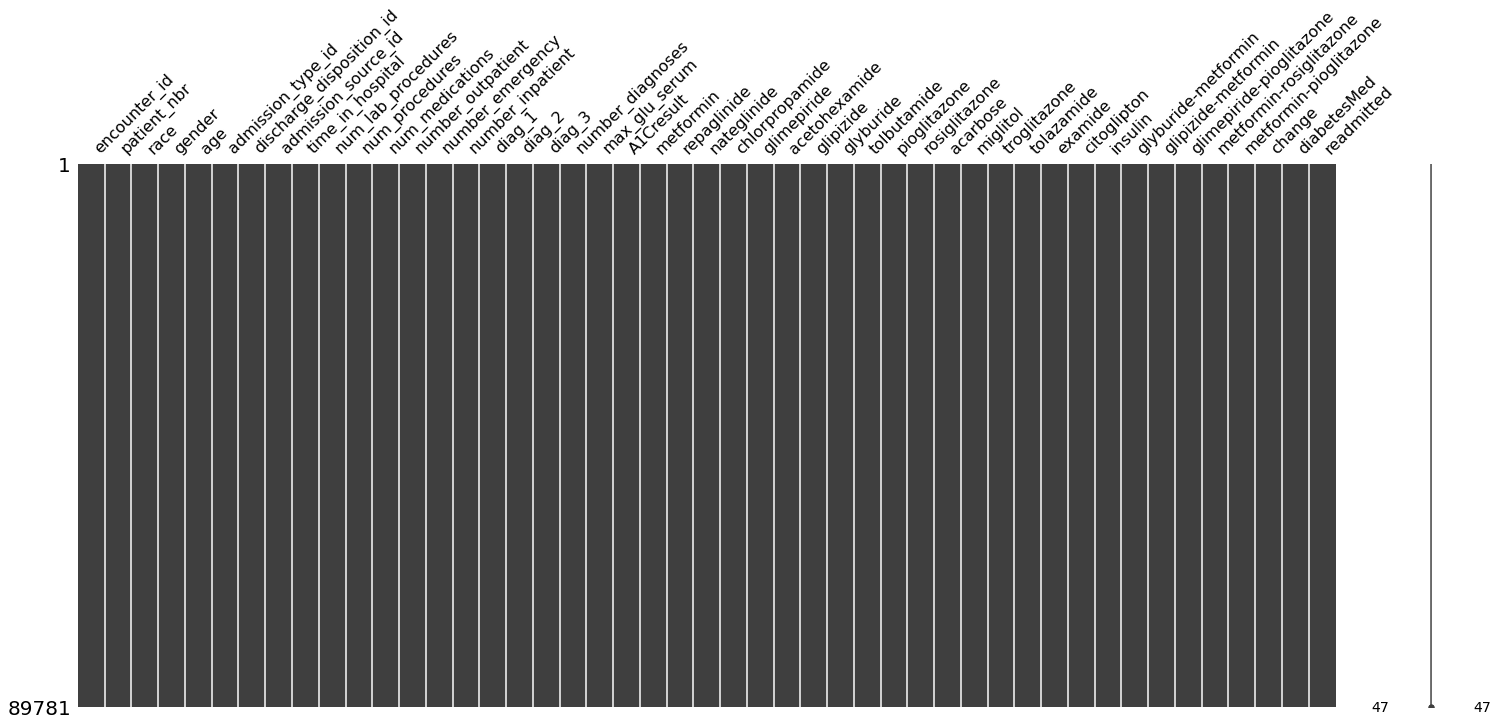

In [7]:
for col in df_original.columns:
    df_original = df_original[df_original[col].notnull()]
df_original = df_original[df_original.gender != 'Unknown/Invalid']

mn.matrix(df_original)

In [8]:
#THERE IS NO CHANGING ORIGINAL
y_df_orginal = df_original['readmitted']
df_original.drop(columns=['encounter_id', 'patient_nbr','readmitted'],axis=1, inplace=True)

In [21]:
#create the encoder
categorical_headers = ['race', 'gender', 'age', 
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'num_medications', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton',
    'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed']
enocders = dict()
for col in categorical_headers:
    # integer encoded variables
    print(col)
    encoders[col] = LabelEncoder() # save the encoder
    df_original[col+'_int'] = encoders[col].fit_transform(df_original[col])

#THERE IS NO CHANGING ORIGINAL
X_train_df, X_test_df, y_train_df, y_test_df = \
    train_test_split(df_original, y_df_orginal, test_size=0.5, random_state=25)

X_train_df = deepcopy(X_train_df)

X_test_df = deepcopy(X_test_df)

race
gender
age
admission_type_id
discharge_disposition_id
admission_source_id
num_medications
max_glu_serum
A1Cresult
metformin
repaglinide
nateglinide
chlorpropamide
glimepiride
acetohexamide
glipizide
glyburide
tolbutamide
pioglitazone
rosiglitazone
acarbose
miglitol
troglitazone
tolazamide
examide
citoglipton
insulin
glyburide-metformin
glipizide-metformin
glimepiride-pioglitazone
metformin-rosiglitazone
metformin-pioglitazone
change
diabetesMed


In [18]:
categorical_headers_new = []
categorical_headers = ['race', 'gender', 'age', 
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'num_medications', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton',
    'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed']
for col in categorical_headers:
    if len(X_train_df[col].unique()) != len(X_test_df[col].unique()):
        X_train_df = X_train_df.drop(columns=col)
        X_test_df = X_test_df.drop(columns=col)
    else:
        categorical_headers_new.append(col)

In [19]:
categorical_headers

['race',
 'gender',
 'age',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'num_medications',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed']

#### Turn all catagorical data into intergers

In [26]:
df_processed = deepcopy(df_original)
encoders = dict() 
categorical_headers = categorical_headers_new


numeric_headers = ['time_in_hospital', 'num_lab_procedures', 'num_procedures','number_outpatient','number_emergency'
                    ,'number_inpatient','diag_1','diag_2', 'diag_3','number_diagnoses']


for col in categorical_headers:
    encoders[col] = LabelEncoder() # save the encoder
    
    df_original[col+'_int'] = encoders[col].fit_transform(df_original[col])
    X_train_df[col+'_int'] = encoders[col].transform(X_train_df[col])
    X_test_df[col+'_int'] = encoders[col].transform(X_test_df[col])
    
for col in numeric_headers:
    X_train_df[col] = X_train_df[col].astype(np.float)
    X_test_df[col] = X_test_df[col].astype(np.float)
    
    ss = StandardScaler()
    X_train_df[col] = ss.fit_transform(X_train_df[col].values.reshape(-1, 1))
    X_test_df[col] = ss.transform(X_test_df[col].values.reshape(-1, 1))

### Identify Groups to Combine

* We think it will be easier for a cutomer to continue service if it is done automatically, therefore we would like to combine **Paperless billing, payment method, and contract.**
* We would also like to group the demographic data, **SeniorCitizen, Partner, Dependents, Gender**
* We want to group what services they opted into, **StreamingTv, StreamingMovies**
* Lastly we want to group **PhoneService, MultipleLines and InternetService**

TODO: Come back to the left over categories

### Create Cross Columns

In [27]:
categorical_headers

['race',
 'gender',
 'age',
 'admission_type_id',
 'admission_source_id',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'examide',
 'citoglipton',
 'insulin',
 'glipizide-metformin',
 'metformin-rosiglitazone',
 'change',
 'diabetesMed']

In [37]:
#cross_columns = [['race', 'gender', 'age', 'admission_type_id','change'],
#                 ['max_glu_serum','A1Cresult','metformin'],
#                 ['repaglinide','nateglinide','glimepiride','glipizide','glyburide',
#                     'tolbutamide'],
#                 ['pioglitazone','rosiglitazone','metformin-rosiglitazone'],
#                 ['glipizide-metformin','metformin-rosiglitazone']]
#
cross_columns = [['race', 'gender', 'age'],
                 ['admission_type_id', 'admission_source_id', 'max_glu_serum', 'A1Cresult',
                   'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
                   'glipizide', 'glyburide'],
                 ['tolbutamide', 'pioglitazone', 'rosiglitazone', 'examide', 'citoglipton',
                  'insulin', 'glipizide-metformin', 'metformin-rosiglitazone', 'change',
                  'diabetesMed']]

cross_col_df_names = []
for cols_list in cross_columns:
    # encode as ints for the embedding
    enc = LabelEncoder()
    
    # 1. create crossed labels by join operation
    X_crossed_train = X_train_df[cols_list].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = X_test_df[cols_list].apply(lambda x: '_'.join(x), axis=1)
    
    # get a nice name for this new crossed column
    cross_col_name = '_'.join(cols_list)
    
    # 2. encode as integers
    enc.fit(np.hstack((X_crossed_train.to_numpy(),  X_crossed_test.to_numpy())))
    
    # 3. Save into dataframe with new name
    X_train_df[cross_col_name] = enc.transform(X_crossed_train)
    X_test_df[cross_col_name] = enc.transform(X_crossed_test)
    
    # keep track of the new names of the crossed columns
    cross_col_df_names.append(cross_col_name) 
    

TypeError: sequence item 1: expected str instance, int found

In [29]:
X_train_df[cross_col_df_names].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44890 entries, 85839 to 34400
Data columns (total 5 columns):
 #   Column                                                               Non-Null Count  Dtype
---  ------                                                               --------------  -----
 0   race_gender_age_admission_type_id_change                             44890 non-null  int32
 1   max_glu_serum_A1Cresult_metformin                                    44890 non-null  int32
 2   repaglinide_nateglinide_glimepiride_glipizide_glyburide_tolbutamide  44890 non-null  int32
 3   pioglitazone_rosiglitazone_metformin-rosiglitazone                   44890 non-null  int32
 4   glipizide-metformin_metformin-rosiglitazone                          44890 non-null  int32
dtypes: int32(5)
memory usage: 1.2 MB


In [30]:
y_test_df.replace(to_replace=['NO','>30','<30'], value=[0,1,2], inplace=True)
y_train_df.replace(to_replace=['NO','>30','<30'], value=[0,1,2], inplace=True)

In [31]:
categorical_headers_ints = [x+'_int' for x in categorical_headers]

In [32]:
# get crossed columns
X_train_crossed = X_train_df[cross_col_df_names].to_numpy()
X_test_crossed = X_test_df[cross_col_df_names].to_numpy()

# save categorical features
X_train_cat = X_train_df[categorical_headers_ints].to_numpy() 
X_test_cat = X_test_df[categorical_headers_ints].to_numpy() 

# and save off the numeric features
X_train_num =  X_train_df[numeric_headers].to_numpy()
X_test_num = X_test_df[numeric_headers].to_numpy()

crossed_outputs = [] # this is where we will keep track of output of each branch

# CROSSED DATA INPUT
input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
for idx,col in enumerate(cross_col_df_names):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(X_train_df[col].max(),X_test_df[col].max())+1
    
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_crossed, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    crossed_outputs.append(x)
    

# now concatenate the outputs and add a fully connected layer
wide_branch = concatenate(crossed_outputs, name='wide_concat')

# reset this input branch
all_deep_branch_outputs = []

# CATEGORICAL DATA INPUT
input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
for idx,col in enumerate(categorical_headers_ints):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(X_train_df[col].max(),X_test_df[col].max())+1
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_cat, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    all_deep_branch_outputs.append(x)
    
# NUMERIC DATA INPUT
# create dense input branch for numeric
input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
x_dense = Dense(units=100, activation='relu',name='num_1')(input_num)
    
all_deep_branch_outputs.append(x_dense)


# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=100,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep3')(deep_branch)
deep_branch = Dense(units=12,activation='relu', name='deep4')(deep_branch)
    
# merge the deep and wide branch
final_branch = concatenate([wide_branch, deep_branch],
                           name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

model = Model(inputs=[input_crossed,input_cat,input_num], 
              outputs=final_branch)


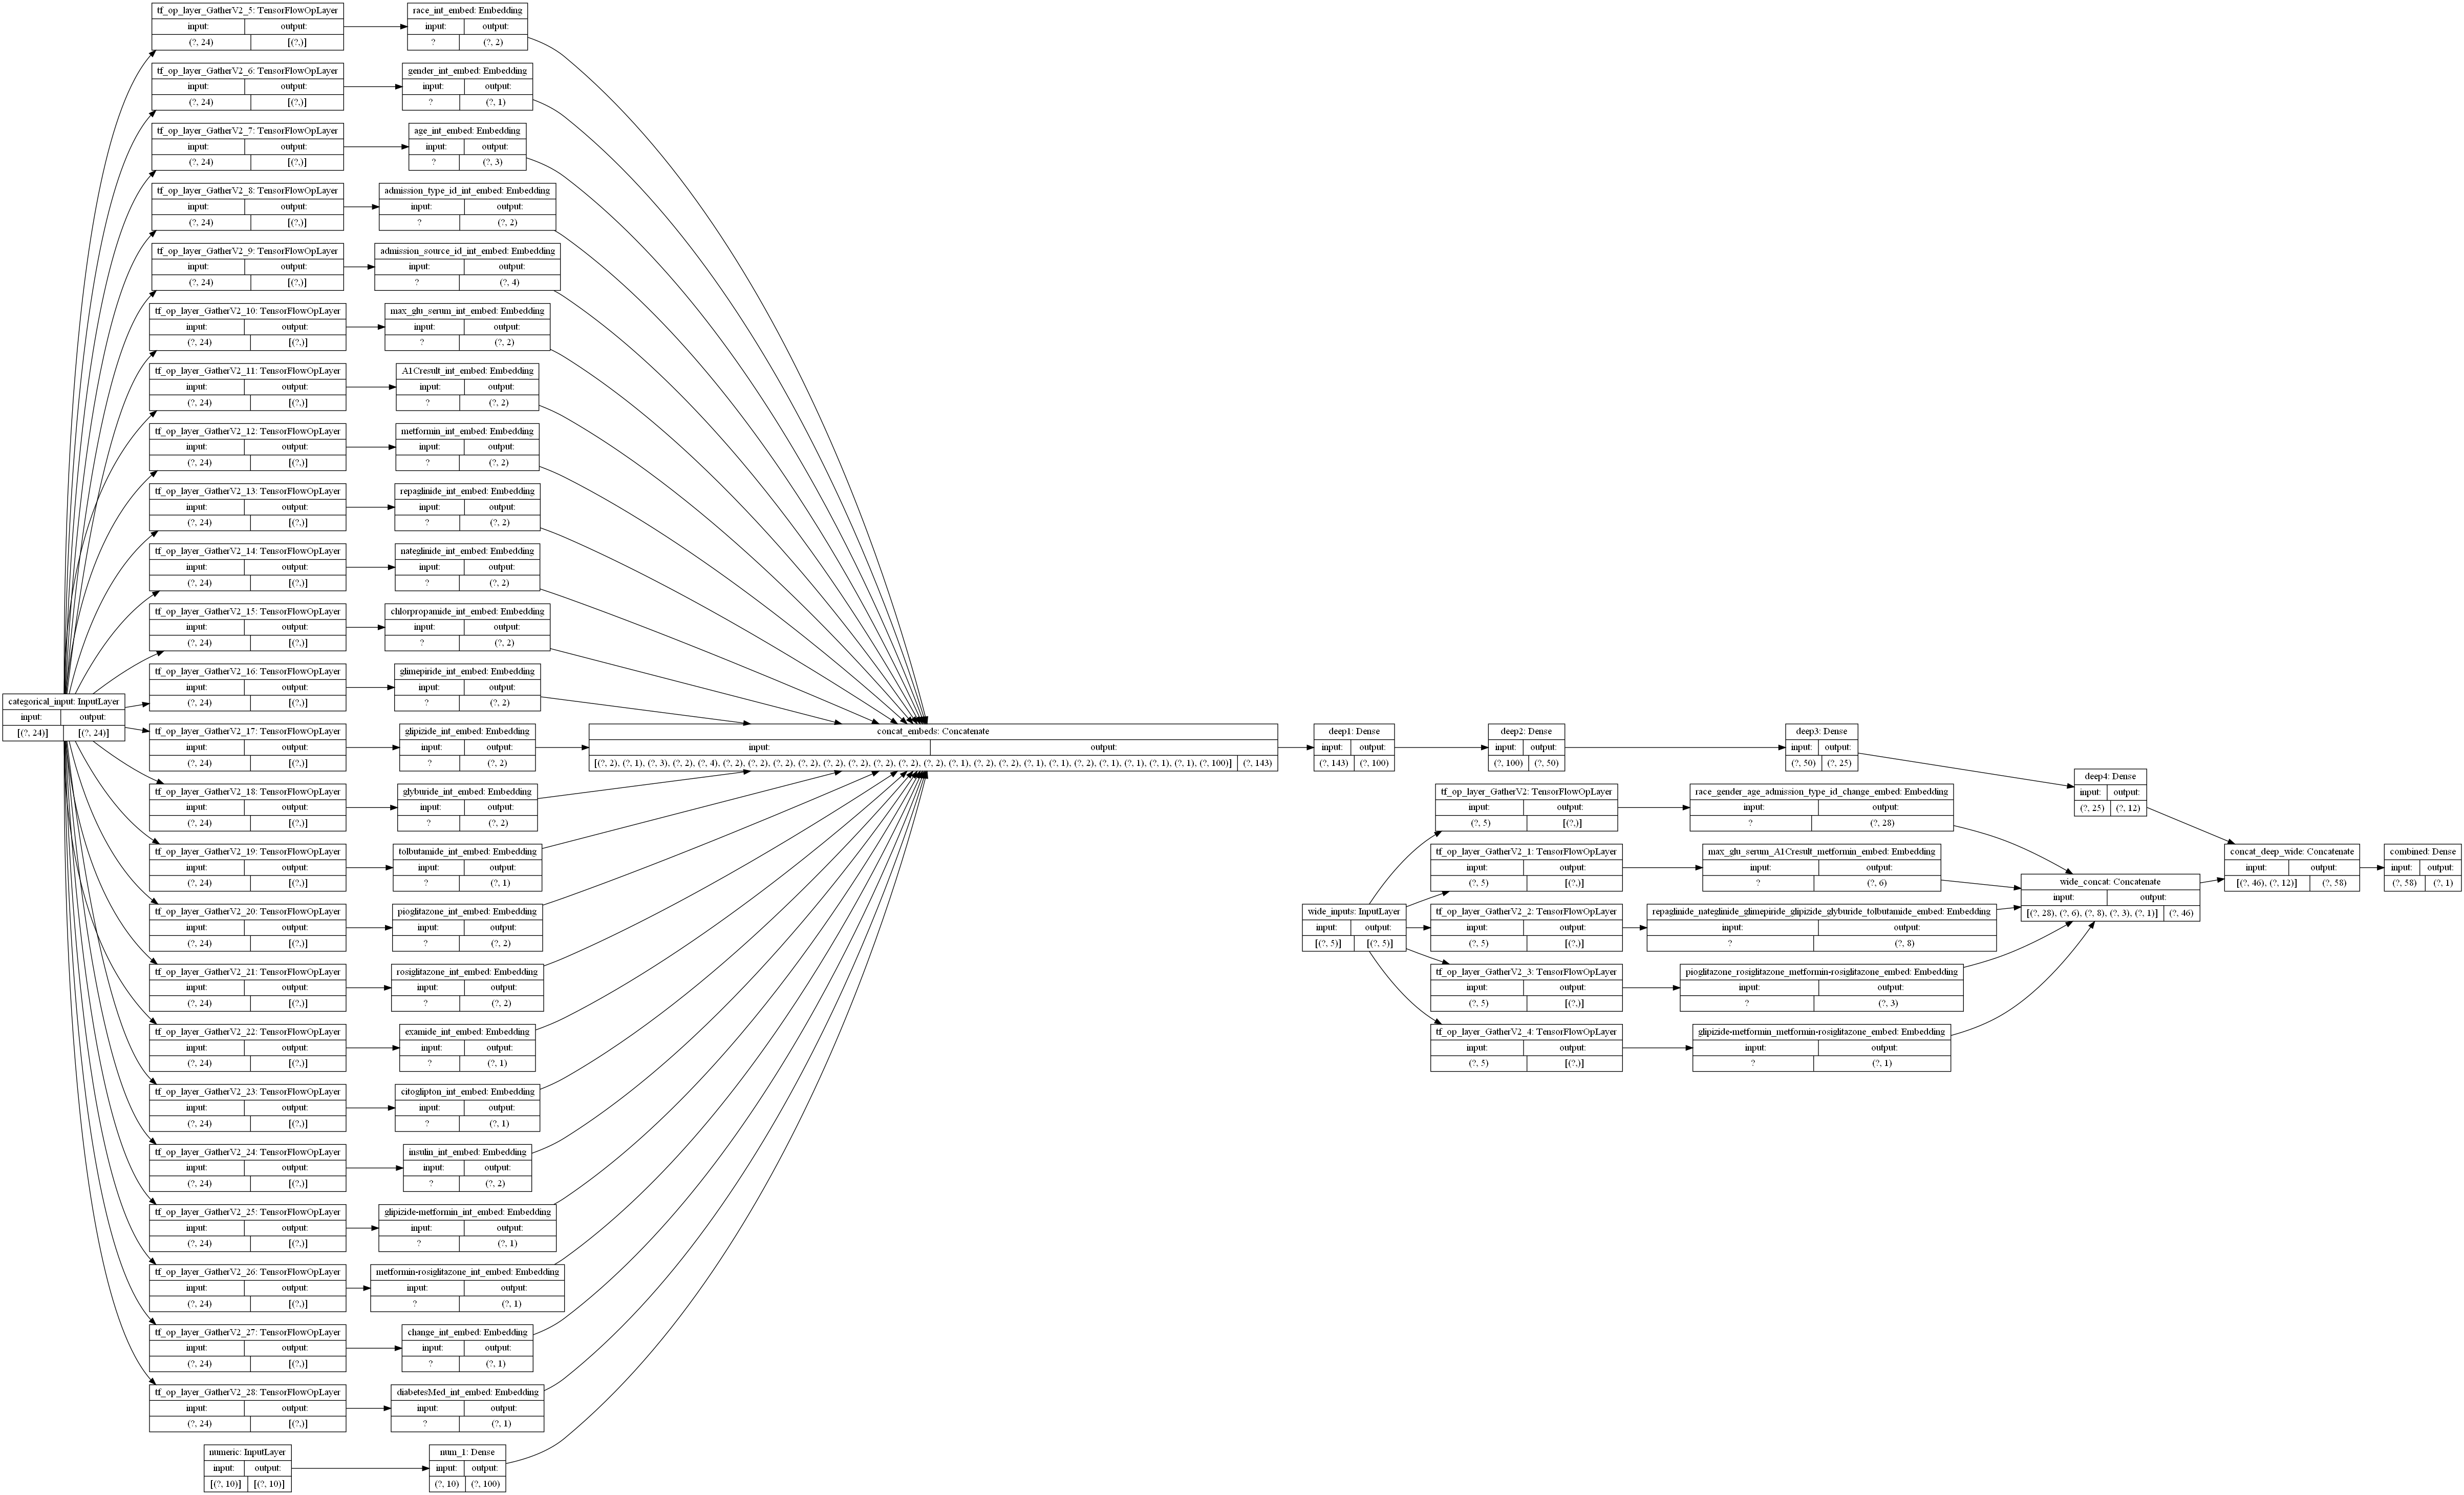

In [33]:
# you will need to install pydot properly on your machine to get this running
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [34]:
# you will need to install pydot properly on your machine to get this running
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=5
)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
categorical_input (InputLayer)  [(None, 24)]         0                                            
__________________________________________________________________________________________________
tf_op_layer_GatherV2_5 (TensorF [(None,)]            0           categorical_input[0][0]          
__________________________________________________________________________________________________
tf_op_layer_GatherV2_6 (TensorF [(None,)]            0           categorical_input[0][0]          
__________________________________________________________________________________________________
tf_op_layer_GatherV2_7 (TensorF [(None,)]            0           categorical_input[0][0]          
_______________________________________________________________________________________

In [35]:
%%time

model.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=['accuracy'])

# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress
history = model.fit([X_train_crossed,X_train_cat,X_train_num],
                    y_train_df.to_numpy(), 
                    epochs=50, 
                    batch_size=32, 
                    verbose=1, 
                    validation_data = ([X_test_crossed,X_test_cat,X_test_num],
                                       y_test_df.to_numpy()))

Epoch 1/50
1403/1403 [==============================] - 3s 2ms/step - loss: 0.4744 - accuracy: 0.4133 - val_loss: 0.4721 - val_accuracy: 0.3606
Epoch 2/50
1403/1403 [==============================] - 2s 2ms/step - loss: 0.4703 - accuracy: 0.3571 - val_loss: 0.4698 - val_accuracy: 0.3547
Epoch 3/50
1403/1403 [==============================] - 2s 2ms/step - loss: 0.4684 - accuracy: 0.3548 - val_loss: 0.4682 - val_accuracy: 0.3542
Epoch 4/50
1403/1403 [==============================] - 2s 2ms/step - loss: 0.4668 - accuracy: 0.3547 - val_loss: 0.4667 - val_accuracy: 0.3543
Epoch 5/50
1403/1403 [==============================] - 2s 2ms/step - loss: 0.4652 - accuracy: 0.3548 - val_loss: 0.4651 - val_accuracy: 0.3546
Epoch 6/50
1403/1403 [==============================] - 2s 2ms/step - loss: 0.4633 - accuracy: 0.3560 - val_loss: 0.4631 - val_accuracy: 0.3570
Epoch 7/50
1403/1403 [==============================] - 2s 2ms/step - loss: 0.4610 - accuracy: 0.3603 - val_loss: 0.4607 - val_accuracy:

In [36]:
yhat = np.round(model.predict([X_test_crossed,X_test_cat,X_test_num]))
print(mt.confusion_matrix(y_test_df.to_numpy(),yhat))
print(mt.classification_report(y_test_df.to_numpy(),yhat))


[[11908 12049     0]
 [ 4965 10922     0]
 [ 1352  3695     0]]
              precision    recall  f1-score   support

           0       0.65      0.50      0.56     23957
           1       0.41      0.69      0.51     15887
           2       0.00      0.00      0.00      5047

    accuracy                           0.51     44891
   macro avg       0.35      0.39      0.36     44891
weighted avg       0.49      0.51      0.48     44891



C:\Users\Steven\anaconda3\envs\mlenv2020\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(max(yhat))
print(min(yhat))